### How do we choose $k=16$ components to be our fiducial model? The answer is complicated. Here, we show the unsupervised portion of the answer - that the F1 score and AUPRC metrics really do point to $k=15-20$, and by some measures, they point to $k=16$ specifically. 

### The reality is that there is no true "optimal value" of $k$ in this range. We performed NMF for values of $k$ between $k=4$ and $k=36$ in increments of 4, and then all values of $k$ between $k=10$ and $k=20$. Although the elbow method points us towards $k=16$ or $k=17$ as an inflection point for the first derivative of AUPRC and F1, our evidence from this unsupervised metric is a bit murky. To assist us in choosing a specific value of $k$ given these constraints, we also developed a "semi-supervised" metric using our knowledge of the anatomical associations of the biosamples. 

Note: there are other accepted metrics in the literature for choosing an optimal number of $k$. One is cophenetic correlation, which measures concurence of major component between different random initalizations for a given $k$. We find that cophenetic correlation is not a sensitive enough metric within the range of $k$ we are considering, and there is no clear optimum. Moreover, we do not use random initialization for our fiducial model, which would make the results even less meaingful. 

We also investigated an additional unsupervised metric that compared the incramental benefit of increasing $k$ between our dataset and a uniform random matrix with the same dimensions as our dataset, which was also forced to be equally sparse as our dataset. We found that $k \approx 200$ was the point where the typical decrement in reconstruction error by increasing $k$ became indistinguishable between the real and random data. Since $k=200$ is not a realistically interpretable model, we chose to set this possibility aside.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('/Users/amuratov/gits/EncodeNMF')


In [3]:
NC_ar = [4,8,10,11,12,13,14,15,16,17,18,19,20,24,28,32,36]

In [4]:
NC_ar = np.array(NC_ar)

In [5]:
import OONMF 
import OONMFhelpers as OH

# First we try to find the optimal decision boundary for F1 score analysis

<Figure size 432x288 with 0 Axes>

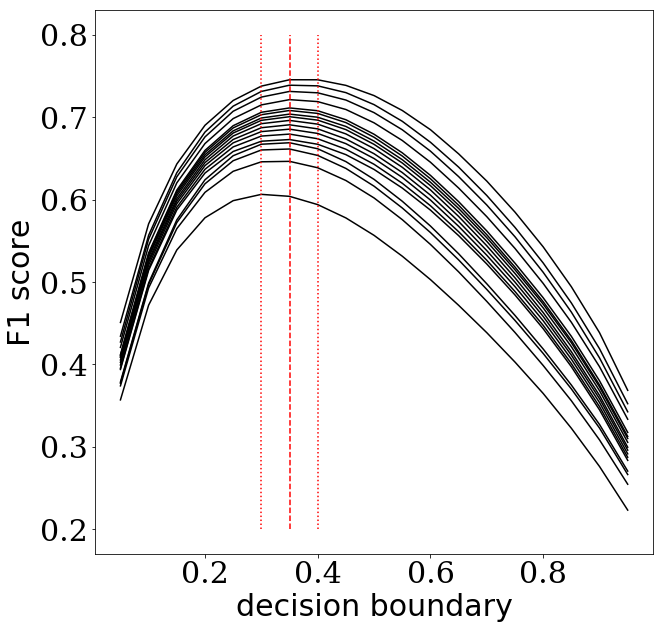

In [6]:
plt.clf()
plt.figure(figsize=(10,10))
prAUC_ar = []
for comp in NC_ar:
    finname = '2018-06-08NC'+str(comp)+'_NNDSVD_TotalPR.txt'
    DF = pd.read_table(finname)
    prec = DF.TP.values / (DF.TP.values + DF.FP.values)
    recall = DF.TP.values / (DF.TP.values + DF.FN.values)
    F1 = 2*prec*recall / (prec+recall)
    prAUC_ar.append(np.trapz([1] + list(recall) + [0], [0] + list(prec) +[1]))
    plt.plot(DF.threshold.values, F1, '-k')

    
plt.plot([0.35, 0.35], [0.2, 0.8], '--r')
plt.plot([0.4, 0.4], [0.2, 0.8], ':r')
plt.plot([0.3, 0.3], [0.2, 0.8], ':r')
OH.increase_axis_fontsize()
plt.xlabel('decision boundary', fontsize=30)
plt.ylabel('F1 score', fontsize=30)

plt.savefig('22219_PRcurve_montage.pdf', bbox_inches='tight', Transparent=True)
plt.show()
plt.close()


# pretty clear that 0.35 is an ideal decision boundary for most choices of k


# Now lets look at AUPRC vs k
## and the first derivative of AUPRC

<Figure size 432x288 with 0 Axes>

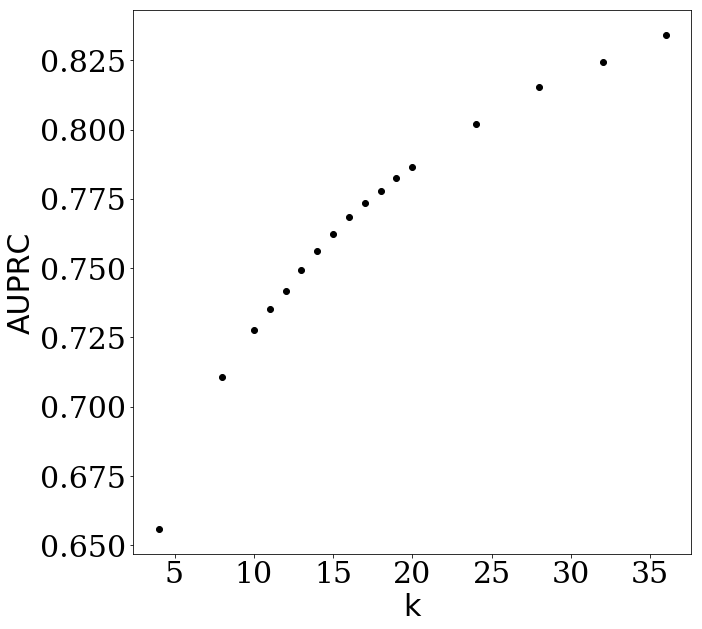

In [7]:
plt.clf()
plt.figure(figsize=(10,10))
plt.plot(NC_ar, prAUC_ar, 'ok')
OH.increase_axis_fontsize()
plt.xlabel('k', fontsize=30)
plt.ylabel('AUPRC', fontsize=30)
#plt.ylim([0,1])
plt.savefig('22219_AUPRC.pdf', bbox_inches='tight', Transparent=True)
plt.show()
plt.close()

<Figure size 432x288 with 0 Axes>

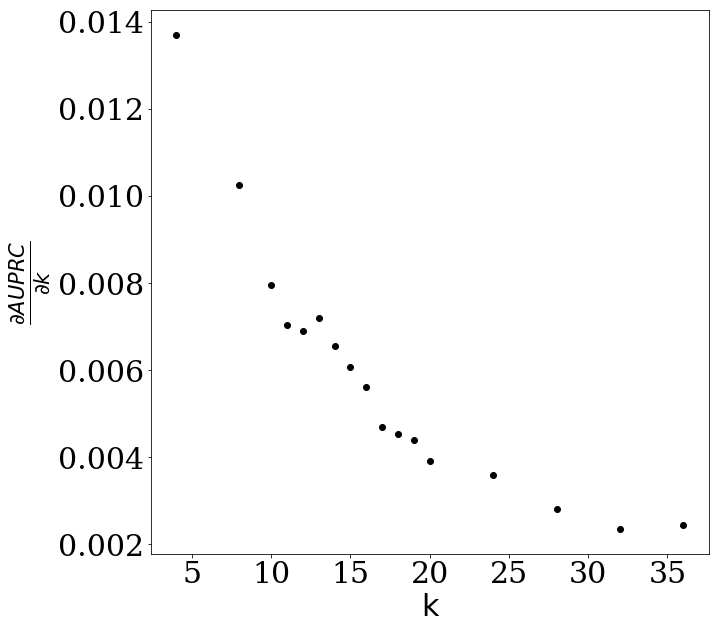

In [8]:
plt.clf()
plt.figure(figsize=(10,10))
plt.plot(NC_ar, np.gradient(prAUC_ar, NC_ar), 'ok')
OH.increase_axis_fontsize()
plt.xlabel('k', fontsize=30)
plt.ylabel(r'$\frac{\partial AUPRC}{\partial k}$', fontsize=30)
plt.savefig('22219_gradient_AUPRC.pdf', bbox_inches='tight', Transparent=True)
plt.show()
plt.close()

### pretty clear that the first derivative flattens out somewhere between 16 and 20. Butwhere exactly does it happen

Lets see the same thing for F1

In [9]:
F1_ar733 = []
for comp in NC_ar:
    finname = '2018-06-08NC'+str(comp)+'_NNDSVD_TotalPR.txt'
    DF = pd.read_table(finname)
    prec = DF.TP.values / (DF.TP.values + DF.FP.values)
    recall = DF.TP.values / (DF.TP.values + DF.FN.values)
    F1 = 2*prec*recall / (prec+recall)
    #plt.plot(DF.threshold.values, F1, '--b')
    F1_ar733.append(F1[6])


In [10]:
F1_ar733 = np.array(F1_ar733)

<Figure size 432x288 with 0 Axes>

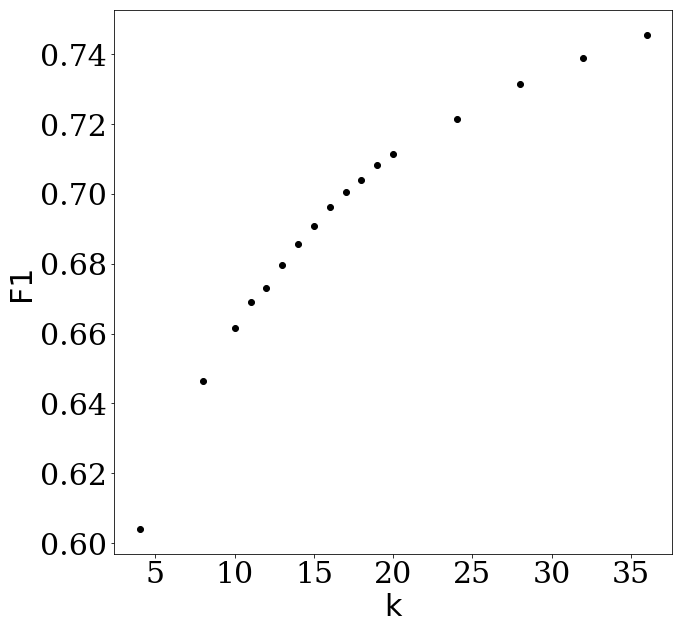

In [11]:
plt.clf()
plt.figure(figsize=(10,10))
plt.plot(NC_ar, F1_ar733, 'ok')
OH.increase_axis_fontsize()
plt.xlabel('k', fontsize=30)
plt.ylabel('F1', fontsize=30)
#plt.ylim([0,1])
plt.savefig('22219_F1.pdf', bbox_inches='tight', Transparent=True)
plt.show()
plt.close()

<Figure size 432x288 with 0 Axes>

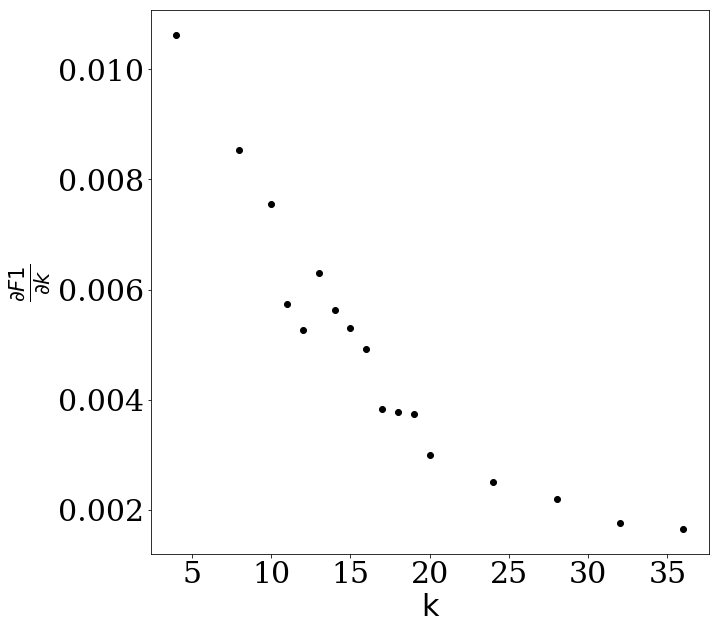

In [12]:
plt.clf()
plt.figure(figsize=(10,10))
plt.plot(NC_ar, np.gradient(F1_ar733, NC_ar), 'ok')
OH.increase_axis_fontsize()
plt.xlabel('k', fontsize=30)
plt.ylabel(r'$\frac{\partial F1}{\partial k}$', fontsize=30)
plt.savefig('22219_gradient_F1.pdf', bbox_inches='tight', Transparent=True)
plt.show()
plt.close()

## F1 shows the same sstory. Now we can try to apply an "elbow" method to figure out where we start hitting diminishing reutnrs for increasking k 

### first, lets search all iterations 

In [13]:
from scipy.stats import linregress

In [15]:
NC_ar = np.array(NC_ar)
prAUC_ar = np.array(prAUC_ar)
F1_ar733 = np.array(F1_ar733)

In [16]:
cut = (NC_ar>=4) * (NC_ar<=36)
myslope = linregress(NC_ar[cut], prAUC_ar[cut])[0]
myintercept = linregress(NC_ar[cut], prAUC_ar[cut])[1]
x_fit = np.arange(3,37)
y_fit = x_fit*myslope + myintercept
best_NC = 0
best_residual = -9999
for i in range(len(cut[cut])):
    residual =  prAUC_ar[cut][i] - (NC_ar[cut][i]*myslope + myintercept)
    print(NC_ar[cut][i], prAUC_ar[cut][i] - (NC_ar[cut][i]*myslope + myintercept))
    if residual > best_residual:
        best_residual = residual
        best_NC = NC_ar[cut][i]
best_index = np.argwhere(NC_ar[cut] == best_NC)[0][0]


4 -0.042838268568757054
8 -0.007718025538862694
10 -0.0004700426357628906
11 0.0022860633369005123
12 0.0037800322662685515
13 0.006234401715247362
14 0.00834118961908381
15 0.0095346173475519
16 0.010643976545587908
17 0.010949272428685264
18 0.010215414091473196
19 0.010173864404694255
20 0.009205666711553762
24 0.004817455052394504
28 -0.0013610879983584345
32 -0.011951648743418808
36 -0.021842880034280476


<Figure size 432x288 with 0 Axes>

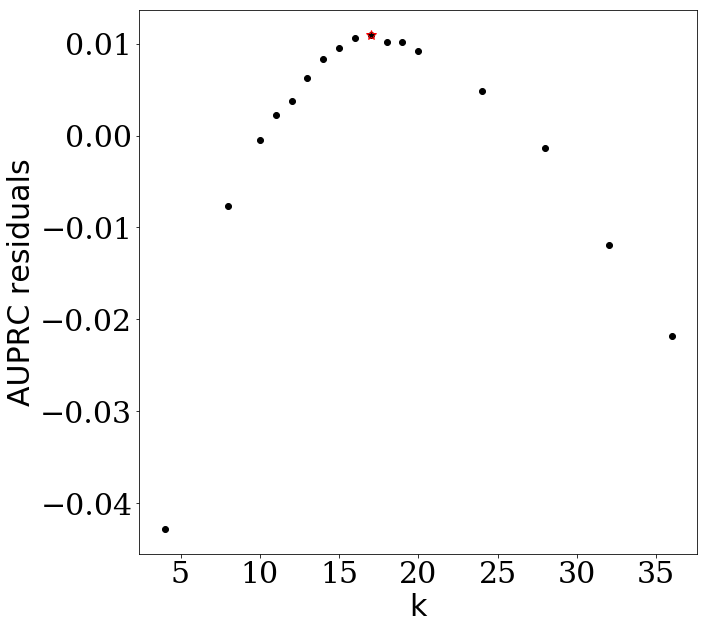

In [19]:
plt.clf()
plt.figure(figsize=(10,10))

plt.plot(NC_ar[cut], prAUC_ar[cut] -  (NC_ar[cut]*myslope + myintercept), 'ok')
plt.plot([best_NC],[best_residual], '*r', ms=10, fillstyle='none' )
OH.increase_axis_fontsize()

plt.xlabel('k', fontsize=30)
plt.ylabel('AUPRC residuals', fontsize=30)
#plt.tight_layout()

plt.show()

### so k = 17  gives the best fit for residuals. But we can also just look between k = 10 and k=20 for a more precise location of the elbow

In [20]:
cut = (NC_ar>=10) * (NC_ar<=20)
myslope = linregress(NC_ar[cut], prAUC_ar[cut])[0]
myintercept = linregress(NC_ar[cut], prAUC_ar[cut])[1]
x_fit = np.arange(3,37)
y_fit = x_fit*myslope + myintercept
best_NC = 0
best_residual = -9999
for i in range(len(cut[cut])):
    residual =  prAUC_ar[cut][i] - (NC_ar[cut][i]*myslope + myintercept)
    print(NC_ar[cut][i], prAUC_ar[cut][i] - (NC_ar[cut][i]*myslope + myintercept))
    if residual > best_residual:
        best_residual = residual
        best_NC = NC_ar[cut][i]
best_index = np.argwhere(NC_ar[cut] == best_NC)[0][0]


10 -0.0027800647642090004
11 -0.001032762653697894
12 -0.0005475975864820404
13 0.0008979680003443624
14 0.001995952042028515
15 0.0021805759083443066
16 0.0022811312442280185
17 0.0015776232651731892
18 -0.0001650389341911751
19 -0.0012153924831224128
20 -0.0031923940384153138


<Figure size 432x288 with 0 Axes>

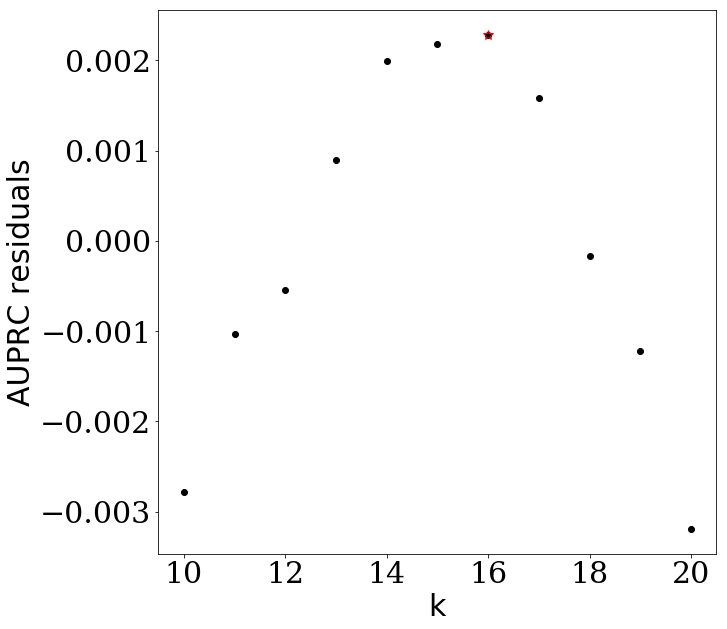

In [21]:
plt.clf()
plt.figure(figsize=(10,10))

plt.plot(NC_ar[cut], prAUC_ar[cut] -  (NC_ar[cut]*myslope + myintercept), 'ok')
plt.plot([best_NC],[best_residual], '*r', ms=10, fillstyle='none' )
OH.increase_axis_fontsize()

plt.xlabel('k', fontsize=30)
plt.ylabel('AUPRC residuals', fontsize=30)
#plt.tight_layout()

plt.show()

### now k=16 is the clear favorite 

### we repeat the exercise for F1

In [22]:
cut = (NC_ar>=4) * (NC_ar<=36)
myslope = linregress(NC_ar[cut], F1_ar733[cut])[0]
myintercept = linregress(NC_ar[cut], F1_ar733[cut])[1]
x_fit = np.arange(3,37)
y_fit = x_fit*myslope + myintercept
best_NC = 0
best_residual = -9999
for i in range(len(cut[cut])):
    residual =  F1_ar733[cut][i] - (NC_ar[cut][i]*myslope + myintercept)
    print(NC_ar[cut][i], F1_ar733[cut][i] - (NC_ar[cut][i]*myslope + myintercept))
    if residual > best_residual:
        best_residual = residual
        best_NC = NC_ar[cut][i]
best_index = np.argwhere(NC_ar[cut] == best_NC)[0][0]

4 -0.035455788268583754
8 -0.008633122470065091
10 -0.0014707056786787964
11 0.0021972819391327114
12 0.0021743017659019426
13 0.004884931948691329
14 0.0069467184588107855
15 0.008317180788810274
16 0.009734652466399929
17 0.010323743756058046
18 0.00956412156189046
19 0.010035516505692677
20 0.009228966748400902
24 0.0036352805812582822
28 -0.0020737595408160114
32 -0.010176308740867612
36 -0.01923301182203685


<Figure size 432x288 with 0 Axes>

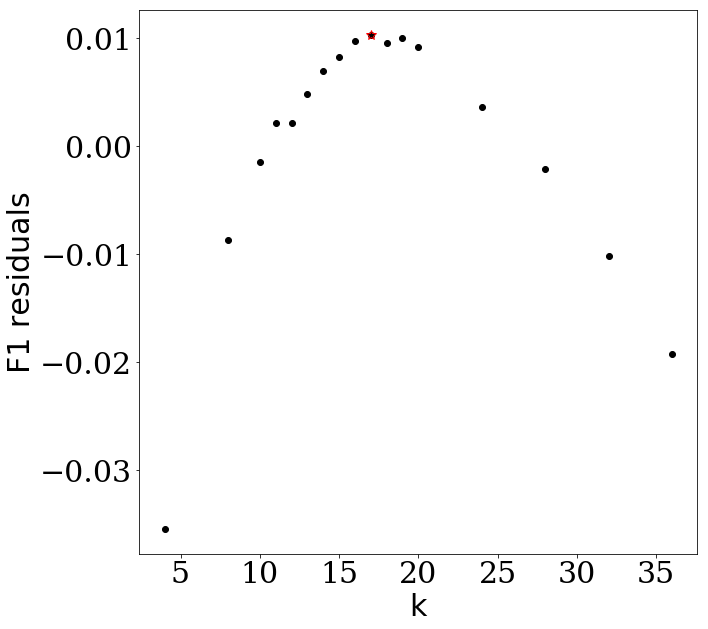

In [23]:
plt.clf()
plt.figure(figsize=(10,10))

plt.plot(NC_ar[cut], F1_ar733[cut] -  (NC_ar[cut]*myslope + myintercept), 'ok')
plt.plot([best_NC],[best_residual], '*r', ms=10, fillstyle='none' )
OH.increase_axis_fontsize()

plt.xlabel('k', fontsize=30)
plt.ylabel('F1 residuals', fontsize=30)
#plt.tight_layout()

plt.show()

### again, k=17 is favored in the broad search, but what about narrow search

In [24]:
cut = (NC_ar>=10) * (NC_ar<=20)
myslope = linregress(NC_ar[cut], F1_ar733[cut])[0]
myintercept = linregress(NC_ar[cut], F1_ar733[cut])[1]
x_fit = np.arange(3,37)
y_fit = x_fit*myslope + myintercept
best_NC = 0
best_residual = -9999
for i in range(len(cut[cut])):
    residual =  F1_ar733[cut][i] - (NC_ar[cut][i]*myslope + myintercept)
    print(NC_ar[cut][i], F1_ar733[cut][i] - (NC_ar[cut][i]*myslope + myintercept))
    if residual > best_residual:
        best_residual = residual
        best_NC = NC_ar[cut][i]
best_index = np.argwhere(NC_ar[cut] == best_NC)[0][0]

10 -0.0025246649109650354
11 4.6174366738149786e-05
12 -0.0010739541466010527
13 0.0005395276960800111
14 0.001504165866090923
15 0.0017774798559819782
16 0.00209780319346331
17 0.0015897461430128823
18 -0.0002670243912631376
19 -0.0008927777875692433
20 -0.0027964758849694515


<Figure size 432x288 with 0 Axes>

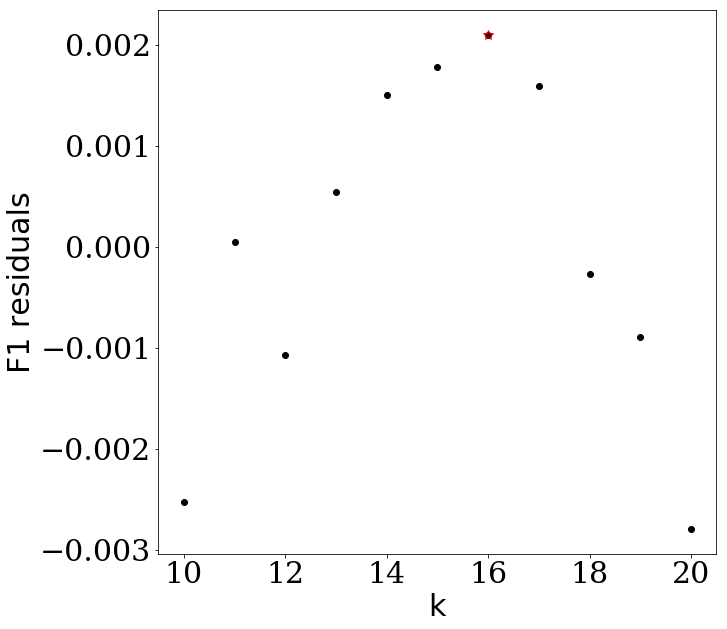

In [25]:
plt.clf()
plt.figure(figsize=(10,10))

plt.plot(NC_ar[cut], F1_ar733[cut] -  (NC_ar[cut]*myslope + myintercept), 'ok')
plt.plot([best_NC],[best_residual], '*r', ms=10, fillstyle='none' )
OH.increase_axis_fontsize()

plt.xlabel('k', fontsize=30)
plt.ylabel('F1 residuals', fontsize=30)
#plt.tight_layout()

plt.show()

### k = 16 reigns supreme